In [ ]:
# Install required libraries
!pip install tensorflow opencv-python mediapipe matplotlib seaborn streamlit


INFO: pip is looking at multiple versions of mediapipe to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatibl

In [ ]:
# Install required libraries
!pip install tensorflow opencv-python mediapipe matplotlib seaborn streamlit


In [ ]:
# Cell 1: install required packages (run once)
!pip install mediapipe opencv-python-headless tensorflow matplotlib seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 9.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found exis

In [ ]:
# Cell 2: imports & basic config
import os, sys, json, math, glob, time
from pathlib import Path
import numpy as np
import cv2
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# MediaPipe helper
mp_pose = mp.solutions.pose
POSE_LANDMARKS = mp_pose.PoseLandmark  # enum-like

# Useful indices (MediaPipe Pose)
IDX = {
    "nose": 0,
    "left_shoulder": 11, "right_shoulder": 12,
    "left_elbow": 13, "right_elbow": 14,
    "left_wrist": 15, "right_wrist": 16,
    "left_hip": 23, "right_hip": 24,
    "left_knee": 25, "right_knee": 26,
    "left_ankle": 27, "right_ankle": 28
}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation + train/val split
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    '/content/drive/MyDrive/new_Dataset',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    '/content/drive/MyDrive/new_Dataset',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 217 images belonging to 9 classes.
Found 53 images belonging to 9 classes.


In [ ]:
print("Classes:", train_gen.class_indices)


Classes: {'Ardhamandalam Augmented': 0, 'Bramha Augmented': 1, 'Garuda Augmented': 2, 'Muzhumandi Augmented': 3, 'Nagabandham Augmented': 4, 'Nataraj Augmented': 5, 'Prenkhana Augmented': 6, 'Samapadam Augmented': 7, 'Swastika Augmented': 8}


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False   # Freeze base

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(len(train_gen.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 71s 10s/step - accuracy: 0.6891 - loss: 0.8353 - val_accuracy: 1.0000 - val_loss: 0.0084
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9951 - loss: 0.0320 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9988 - loss: 0.0056 - val_accuracy: 1.0000 - val_loss: 1.4153e-04
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 1.0000 - val_loss: 3.6573e-04
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 1.3035e-04
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 9.9480e-06
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 1.0000 - loss: 7.0788e-04 - val_accuracy: 1.0000 - val_loss: 1.4871e-05
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 1.0000 - loss: 2.0242e-04 - val_accuracy: 1.000

In [ ]:
# Full model save (architecture + weights + optimizer state)
model.save("/content/drive/MyDrive/bharatnatyam_pose_model.h5")
print("Model saved successfully!")


Model saved successfully!


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/bharatnatyam_pose_model.h5")
print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# ek random test image ka path do
img_path = "/content/drive/MyDrive/new_Dataset/Nataraj Augmented/dr_0_1059.jpg"

# image load & preprocess
img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

# prediction
pred = model.predict(x)
class_idx = np.argmax(pred)
class_labels = list(train_gen.class_indices.keys())

print("Predicted Class:", class_labels[class_idx])


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: Nataraj Augmented


In [ ]:
from google.colab import output
from IPython.display import Javascript

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);
      document.body.appendChild(div);

      const video = document.createElement('video');
      div.appendChild(video);
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      video.srcObject = stream;
      await video.play();

      // Resize output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    takePhoto({{quality}}).then(dataUrl => {
      const data = dataUrl.split(',')[1];
      const bytes = Uint8Array.from(atob(data), c => c.charCodeAt(0));
      google.colab.kernel.invokeFunction('notebook.takePhoto', [bytes], {});
    });
  ''')

  data = output.eval_js('takePhoto({})'.format(quality))
  with open(filename, 'wb') as f:
    f.write(data)
  return filename


In [ ]:
# Dance Pose Feedback System - Complete Implementation
# Step-by-step implementation for Colab

# ================================
# STEP 1: Import Required Libraries
# ================================

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
import pandas as pd
from pathlib import Path
import mediapipe as mp
import json

# Install required packages (run these in separate cells first)
"""
!pip install mediapipe
!pip install opencv-python
"""

print("✅ All libraries imported successfully!")

# ================================
# STEP 2: Dataset Setup & Exploration
# ================================

# Update this path to your dataset location
DATASET_PATH = "/content/drive/MyDrive/new_Dataset"  # Change this path!

class DatasetExplorer:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.pose_classes = []
        self.class_counts = {}

    def explore_dataset(self):
        """Explore and analyze the dataset structure"""
        print("🔍 Exploring Dataset Structure...")

        if not os.path.exists(self.dataset_path):
            print(f"❌ Dataset path not found: {self.dataset_path}")
            return False

        # Get all pose classes (folders)
        self.pose_classes = [d for d in os.listdir(self.dataset_path)
                            if os.path.isdir(os.path.join(self.dataset_path, d))]

        print(f"📂 Found {len(self.pose_classes)} pose classes:")

        # Count images per class
        for pose_class in self.pose_classes:
            class_path = os.path.join(self.dataset_path, pose_class)
            image_files = [f for f in os.listdir(class_path)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
            self.class_counts[pose_class] = len(image_files)
            print(f"   {pose_class}: {len(image_files)} images")

        return True

    def visualize_dataset(self):
        """Visualize dataset distribution and sample images"""
        # Plot class distribution
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        poses = list(self.class_counts.keys())
        counts = list(self.class_counts.values())

        plt.bar(poses, counts, color='skyblue', alpha=0.7)
        plt.title('Dataset Distribution')
        plt.xlabel('Pose Classes')
        plt.ylabel('Number of Images')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)

        # Show sample images
        plt.subplot(1, 2, 2)
        if self.pose_classes:
            sample_class = self.pose_classes[0]
            sample_path = os.path.join(self.dataset_path, sample_class)
            sample_images = os.listdir(sample_path)[:1]

            if sample_images:
                img_path = os.path.join(sample_path, sample_images[0])
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow(img)
                plt.title(f'Sample: {sample_class}')
                plt.axis('off')

        plt.tight_layout()
        plt.show()

# Initialize dataset explorer
explorer = DatasetExplorer(DATASET_PATH)

# ================================
# STEP 3: Data Preprocessing Pipeline
# ================================

class DanceDataPreprocessor:
    def __init__(self, dataset_path, img_size=(224, 224), batch_size=32):
        self.dataset_path = dataset_path
        self.img_size = img_size
        self.batch_size = batch_size
        self.num_classes = 0
        self.class_names = []

    def create_data_generators(self, validation_split=0.2):
        """Create train and validation data generators with augmentation"""

        # Data augmentation for training
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=validation_split,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            brightness_range=[0.8, 1.2],
            zoom_range=0.2,
            fill_mode='nearest'
        )

        # Only rescaling for validation
        val_datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=validation_split
        )

        # Create training generator
        train_generator = train_datagen.flow_from_directory(
            self.dataset_path,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            subset='training',
            shuffle=True
        )

        # Create validation generator
        validation_generator = val_datagen.flow_from_directory(
            self.dataset_path,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            subset='validation',
            shuffle=False
        )

        self.num_classes = train_generator.num_classes
        self.class_names = list(train_generator.class_indices.keys())

        print(f"✅ Data generators created successfully!")
        print(f"📊 Training samples: {train_generator.samples}")
        print(f"📊 Validation samples: {validation_generator.samples}")
        print(f"🎯 Number of classes: {self.num_classes}")
        print(f"🏷️  Classes: {self.class_names}")

        return train_generator, validation_generator

    def visualize_augmented_data(self, generator):
        """Visualize augmented training data"""
        plt.figure(figsize=(15, 10))

        # Get a batch of augmented images
        batch_images, batch_labels = next(generator)

        for i in range(min(12, len(batch_images))):
            plt.subplot(3, 4, i + 1)
            plt.imshow(batch_images[i])

            # Get class name from label
            class_idx = np.argmax(batch_labels[i])
            class_name = self.class_names[class_idx]
            plt.title(f'{class_name}')
            plt.axis('off')

        plt.suptitle('Augmented Training Data Samples', fontsize=16)
        plt.tight_layout()
        plt.show()

# Initialize preprocessor
preprocessor = DanceDataPreprocessor(DATASET_PATH)

# ================================
# STEP 4: CNN Model Architecture
# ================================

class DancePoseClassifier:
    def __init__(self, num_classes, img_size=(224, 224)):
        self.num_classes = num_classes
        self.img_size = img_size
        self.model = None
        self.history = None

    def build_custom_cnn(self):
        """Build a custom CNN architecture"""
        model = keras.Sequential([
            # Input layer
            layers.Input(shape=(*self.img_size, 3)),

            # First conv block
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Second conv block
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Third conv block
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Fourth conv block
            layers.Conv2D(256, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Global average pooling instead of flatten
            layers.GlobalAveragePooling2D(),

            # Dense layers
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),

            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),

            # Output layer
            layers.Dense(self.num_classes, activation='softmax')
        ])

        self.model = model
        return model

    def build_transfer_learning_model(self):
        """Build model using transfer learning with MobileNetV2"""
        # Load pretrained MobileNetV2
        base_model = MobileNetV2(
            input_shape=(*self.img_size, 3),
            include_top=False,
            weights='imagenet'
        )

        # Freeze base model layers
        base_model.trainable = False

        # Add custom classifier
        model = keras.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.3),
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        self.model = model
        return model

    def compile_model(self, learning_rate=0.001):
        """Compile the model with optimizer, loss, and metrics"""
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        print("✅ Model compiled successfully!")
        print(f"📋 Model Summary:")
        self.model.summary()

    def train_model(self, train_generator, validation_generator, epochs=50):
        """Train the model with callbacks"""

        # Callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=5,
                min_lr=1e-7,
                verbose=1
            ),
            keras.callbacks.ModelCheckpoint(
                'best_dance_model.h5',
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            )
        ]

        print("🚀 Starting model training...")

        self.history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=callbacks,
            verbose=1
        )

        print("✅ Training completed!")
        return self.history

    def plot_training_history(self):
        """Plot training history"""
        if self.history is None:
            print("❌ No training history found!")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Accuracy
        axes[0, 0].plot(self.history.history['accuracy'], label='Training Accuracy')
        axes[0, 0].plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        axes[0, 0].set_title('Model Accuracy')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Loss
        axes[0, 1].plot(self.history.history['loss'], label='Training Loss')
        axes[0, 1].plot(self.history.history['val_loss'], label='Validation Loss')
        axes[0, 1].set_title('Model Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Top-2 Accuracy (skip if not available)
        axes[1, 0].text(0.5, 0.5, 'Top-2 Accuracy\nnot available in\nthis Keras version',
                        ha='center', va='center', transform=axes[1, 0].transAxes)

        # Learning Rate
        if hasattr(self, 'history') and 'lr' in self.history.history:
            axes[1, 1].plot(self.history.history['lr'])
            axes[1, 1].set_title('Learning Rate')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Learning Rate')
            axes[1, 1].set_yscale('log')
            axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# ================================
# STEP 5: Pose Detection & Feedback System
# ================================

class PoseFeedbackSystem:
    def __init__(self, model, class_names):
        self.model = model
        self.class_names = class_names

        # Initialize MediaPipe
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(
            static_image_mode=True,
            model_complexity=2,
            enable_segmentation=True,
            min_detection_confidence=0.5
        )
        self.mp_drawing = mp.solutions.drawing_utils

        # Reference poses (you'll need to populate this with actual data)
        self.reference_poses = {}

    def extract_keypoints(self, image):
        """Extract pose keypoints from image using MediaPipe"""
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = self.pose.process(image_rgb)

        keypoints = []
        if results.pose_landmarks:
            for landmark in results.pose_landmarks.landmark:
                keypoints.extend([landmark.x, landmark.y, landmark.z])

        return np.array(keypoints), results

    def predict_pose(self, image):
        """Predict pose class from image"""
        # Preprocess image
        img_resized = cv2.resize(image, (224, 224))
        img_array = np.expand_dims(img_resized / 255.0, axis=0)

        # Predict
        predictions = self.model.predict(img_array, verbose=0)
        predicted_class_idx = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class_idx]

        predicted_class = self.class_names[predicted_class_idx]

        return predicted_class, confidence, predictions[0]

    def calculate_pose_score(self, keypoints, reference_keypoints):
        """Calculate similarity score between current and reference pose"""
        if len(keypoints) == 0 or len(reference_keypoints) == 0:
            return 0.0

        # Calculate euclidean distance between keypoints
        distance = np.linalg.norm(keypoints - reference_keypoints)

        # Convert to similarity score (0-100)
        max_possible_distance = np.sqrt(len(keypoints))
        similarity = max(0, 100 * (1 - distance / max_possible_distance))

        return similarity

    def generate_feedback(self, image, target_pose=None):
        """Generate comprehensive feedback for a pose"""
        # Predict pose
        predicted_pose, confidence, all_predictions = self.predict_pose(image)

        # Extract keypoints
        keypoints, pose_results = self.extract_keypoints(image)

        feedback = {
            'predicted_pose': predicted_pose,
            'confidence': float(confidence),
            'all_predictions': {self.class_names[i]: float(all_predictions[i])
                              for i in range(len(self.class_names))},
            'keypoints_detected': len(keypoints) > 0,
            'pose_score': 0.0,
            'feedback_text': []
        }

        # Generate textual feedback
        if confidence > 0.8:
            feedback['feedback_text'].append(f"✅ Great! Detected {predicted_pose} with high confidence ({confidence:.2%})")
        elif confidence > 0.6:
            feedback['feedback_text'].append(f"👍 Good pose detection for {predicted_pose} ({confidence:.2%})")
        else:
            feedback['feedback_text'].append(f"⚠️ Pose detected as {predicted_pose} but with low confidence ({confidence:.2%})")

            # Suggest alternatives
            sorted_predictions = sorted(enumerate(all_predictions), key=lambda x: x[1], reverse=True)
            top_alternatives = [self.class_names[idx] for idx, prob in sorted_predictions[1:3]]
            feedback['feedback_text'].append(f"💡 Could also be: {', '.join(top_alternatives)}")

        if not feedback['keypoints_detected']:
            feedback['feedback_text'].append("⚠️ Pose landmarks not clearly detected. Try better lighting or pose clarity.")

        return feedback

    def visualize_pose_feedback(self, image, feedback, pose_results=None):
        """Visualize pose with feedback overlay"""
        img_copy = image.copy()

        # Draw pose landmarks if available
        if pose_results and pose_results.pose_landmarks:
            self.mp_drawing.draw_landmarks(
                img_copy,
                pose_results.pose_landmarks,
                self.mp_pose.POSE_CONNECTIONS
            )

        # Add text feedback
        y_offset = 30
        for text in feedback['feedback_text']:
            # Remove emojis for OpenCV text rendering
            clean_text = ''.join(char for char in text if ord(char) < 128)
            cv2.putText(img_copy, clean_text, (10, y_offset),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            y_offset += 25

        return img_copy

# ================================
# STEP 6: Video Processing Pipeline
# ================================

class VideoProcessor:
    def __init__(self, feedback_system):
        self.feedback_system = feedback_system

    def process_video(self, video_path, output_path=None, skip_frames=5):
        """Process video and generate pose feedback for each frame"""
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print(f"❌ Error opening video file: {video_path}")
            return None

        # Get video properties
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        print(f"📹 Processing video: {fps}fps, {width}x{height}, {total_frames} frames")

        # Initialize video writer if output path provided
        out = None
        if output_path:
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        frame_results = []
        frame_count = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Process every nth frame to speed up processing
            if frame_count % skip_frames == 0:
                # Generate feedback for this frame
                feedback = self.feedback_system.generate_feedback(frame)

                # Get pose landmarks for visualization
                _, pose_results = self.feedback_system.extract_keypoints(frame)

                # Visualize feedback on frame
                frame_with_feedback = self.feedback_system.visualize_pose_feedback(
                    frame, feedback, pose_results
                )

                # Store results
                frame_results.append({
                    'frame_number': frame_count,
                    'timestamp': frame_count / fps,
                    'feedback': feedback
                })

                # Write frame to output video
                if out:
                    out.write(frame_with_feedback)

                # Show progress
                if frame_count % (skip_frames * 10) == 0:
                    progress = (frame_count / total_frames) * 100
                    print(f"📊 Processing: {progress:.1f}% (Frame {frame_count}/{total_frames})")

            frame_count += 1

        # Clean up
        cap.release()
        if out:
            out.release()

        print("✅ Video processing completed!")
        return frame_results

# ================================
# STEP 7: Main Execution Pipeline
# ================================

def main_pipeline():
    """Main execution pipeline for the dance pose feedback system"""

    print("🎭 Dance Pose Feedback System - Starting Pipeline")
    print("=" * 50)

    # Step 1: Explore dataset
    print("\n📊 STEP 1: Dataset Exploration")
    if not explorer.explore_dataset():
        print("❌ Please update the DATASET_PATH variable with correct path!")
        return

    explorer.visualize_dataset()

    # Step 2: Create data generators
    print("\n🔄 STEP 2: Data Preprocessing")
    train_gen, val_gen = preprocessor.create_data_generators()

    # Visualize some augmented data
    preprocessor.visualize_augmented_data(train_gen)

    # Step 3: Build and train model
    print("\n🧠 STEP 3: Model Building & Training")
    classifier = DancePoseClassifier(preprocessor.num_classes)

    # Choose architecture (uncomment one)
    # classifier.build_custom_cnn()  # Custom CNN
    classifier.build_transfer_learning_model()  # Transfer learning (recommended)

    classifier.compile_model()

    # Train model (adjust epochs as needed)
    history = classifier.train_model(train_gen, val_gen, epochs=20)

    # Plot training results
    classifier.plot_training_history()

    # Step 4: Initialize feedback system
    print("\n🔍 STEP 4: Pose Feedback System")
    feedback_system = PoseFeedbackSystem(classifier.model, preprocessor.class_names)

    print("✅ Dance Pose Feedback System is ready!")
    print("\n🎯 You can now:")
    print("   - Test with individual images: feedback_system.generate_feedback(image)")
    print("   - Process videos: VideoProcessor(feedback_system).process_video(video_path)")
    print("   - Save model: classifier.model.save('dance_pose_model.h5')")

    return classifier, feedback_system

# ================================
# STEP 8: Testing & Demo Functions
# ================================

def test_single_image(feedback_system, image_path):
    """Test feedback system on a single image"""
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Could not load image: {image_path}")
        return

    # Generate feedback
    feedback = feedback_system.generate_feedback(image)

    # Get pose landmarks for visualization
    _, pose_results = feedback_system.extract_keypoints(image)

    # Visualize results
    result_image = feedback_system.visualize_pose_feedback(image, feedback, pose_results)

    # Display results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title('Pose Analysis')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    # Plot prediction probabilities
    classes = list(feedback['all_predictions'].keys())
    probs = list(feedback['all_predictions'].values())

    plt.barh(classes, probs)
    plt.xlabel('Probability')
    plt.title('Pose Predictions')
    plt.xlim(0, 1)

    plt.tight_layout()
    plt.show()

    # Print feedback
    print("📋 Feedback Results:")
    for text in feedback['feedback_text']:
        print(f"   {text}")

def demo_webcam_feedback(feedback_system):
    """Demo real-time webcam feedback (for local use)"""
    print("📷 Starting webcam demo...")
    print("Press 'q' to quit, 's' to save current frame analysis")

    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Generate feedback (every 10th frame to avoid lag)
        if cv2.waitKey(1) & 0xFF != 255:  # Process frame
            feedback = feedback_system.generate_feedback(frame)
            _, pose_results = feedback_system.extract_keypoints(frame)
            frame = feedback_system.visualize_pose_feedback(frame, feedback, pose_results)

        cv2.imshow('Dance Pose Feedback', frame)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('s'):
            cv2.imwrite('webcam_analysis.jpg', frame)
            print("💾 Frame saved as 'webcam_analysis.jpg'")

    cap.release()
    cv2.destroyAllWindows()

# ================================
# Ready to Execute!
# ================================

print("🎭 Dance Pose Feedback System - Ready to Execute!")
print("\nTo start the complete pipeline, run:")
print("classifier, feedback_system = main_pipeline()")
print("\nTo test on a single image:")
print("test_single_image(feedback_system, 'path/to/your/image.jpg')")
print("\nTo process a video:")
print("processor = VideoProcessor(feedback_system)")
print("results = processor.process_video('input_video.mp4', 'output_video.mp4')")

✅ All libraries imported successfully!
🎭 Dance Pose Feedback System - Ready to Execute!

To start the complete pipeline, run:
classifier, feedback_system = main_pipeline()

To test on a single image:
test_single_image(feedback_system, 'path/to/your/image.jpg')

To process a video:
processor = VideoProcessor(feedback_system)
results = processor.process_video('input_video.mp4', 'output_video.mp4')


🎭 Dance Pose Feedback System - Starting Pipeline

📊 STEP 1: Dataset Exploration
🔍 Exploring Dataset Structure...
📂 Found 9 pose classes:
   Swastika Augmented: 112 images
   Nataraj Augmented: 467 images
   Samapadam Augmented: 265 images
   Muzhumandi Augmented: 265 images
   Prenkhana Augmented: 102 images
   Bramha Augmented: 102 images
   Nagabandham Augmented: 265 images
   Garuda Augmented: 102 images
   Ardhamandalam Augmented: 101 images


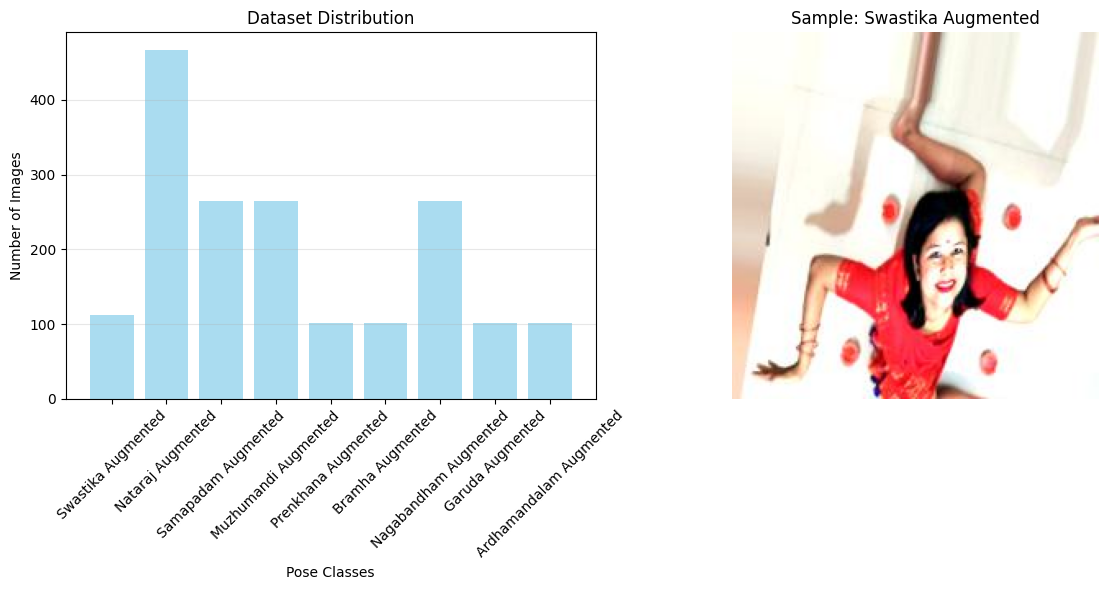


🔄 STEP 2: Data Preprocessing
Found 1427 images belonging to 9 classes.
Found 354 images belonging to 9 classes.
✅ Data generators created successfully!
📊 Training samples: 1427
📊 Validation samples: 354
🎯 Number of classes: 9
🏷️  Classes: ['Ardhamandalam Augmented', 'Bramha Augmented', 'Garuda Augmented', 'Muzhumandi Augmented', 'Nagabandham Augmented', 'Nataraj Augmented', 'Prenkhana Augmented', 'Samapadam Augmented', 'Swastika Augmented']


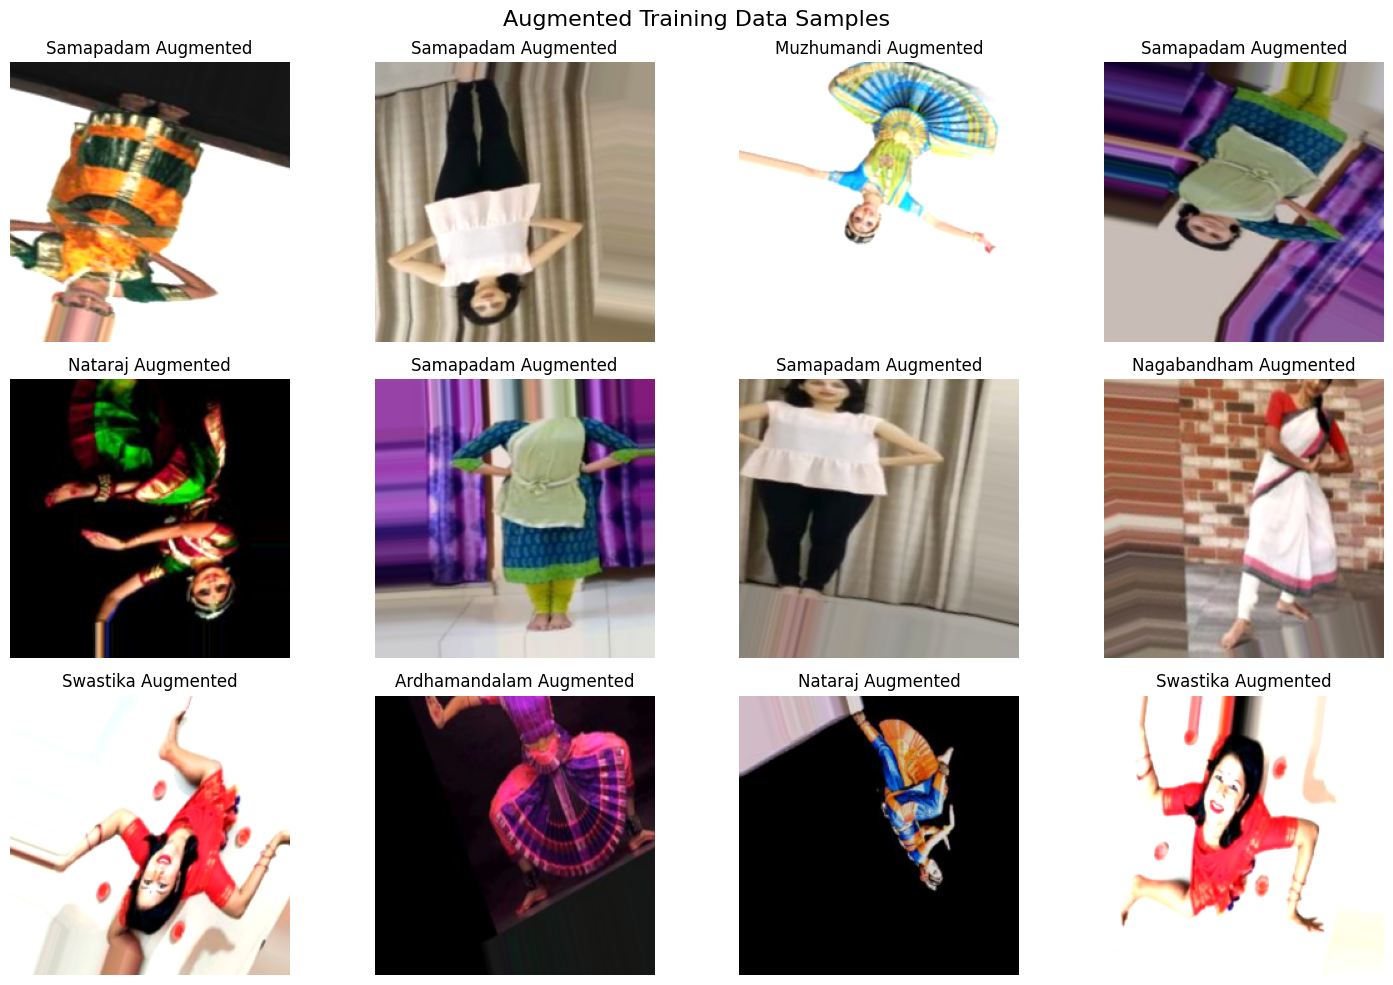


🧠 STEP 3: Model Building & Training
✅ Model compiled successfully!
📋 Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,050,569 (11.64 MB)

 Trainable params: 791,049 (3.02 MB)

 Non-trainable params: 2,259,520 (8.62 MB)

🚀 Starting model training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4142 - loss: 1.9268
Epoch 1: val_accuracy improved from -inf to 0.65254, saving model to best_dance_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.4186 - loss: 1.9110 - val_accuracy: 0.6525 - val_loss: 1.5303 - learning_rate: 0.0010
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9067 - loss: 0.3145
Epoch 2: val_accuracy improved from 0.65254 to 0.71469, saving model to best_dance_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9068 - loss: 0.3139 - val_accuracy: 0.7147 - val_loss: 1.4874 - learning_rate: 0.0010
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9670 - loss: 0.1254
Epoch 3: val_accuracy did not improve from 0.71469
45/45 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9669 - loss: 0.1255 - val_accuracy: 0.7147 - val_loss: 1.6636 - learning_rate: 0.0010
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9604 - loss: 0.1301
Epoch 4: val_accuracy improved from 0.71469 to 0.72881, saving model to best_dance_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9605 - loss: 0.1298 - val_accuracy: 0.7288 - val_loss: 1.7449 - learning_rate: 0.0010
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9715 - loss: 0.0907
Epoch 5: val_accuracy did not improve from 0.72881
45/45 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9715 - loss: 0.0908 - val_accuracy: 0.7203 - val_loss: 2.0538 - learning_rate: 0.0010
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9750 - loss: 0.0708
Epoch 6: val_accuracy did not improve from 0.72881
45/45 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9750 - loss: 0.0708 - val_accuracy: 0.7260 - val_loss: 2.2249 - learning_rate: 0.0010
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9860 - loss: 0.0510
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 7: val_accuracy did not improve from 0.72881
45/45 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9859 - loss: 0.0511 - val_accuracy: 0.7260 - v

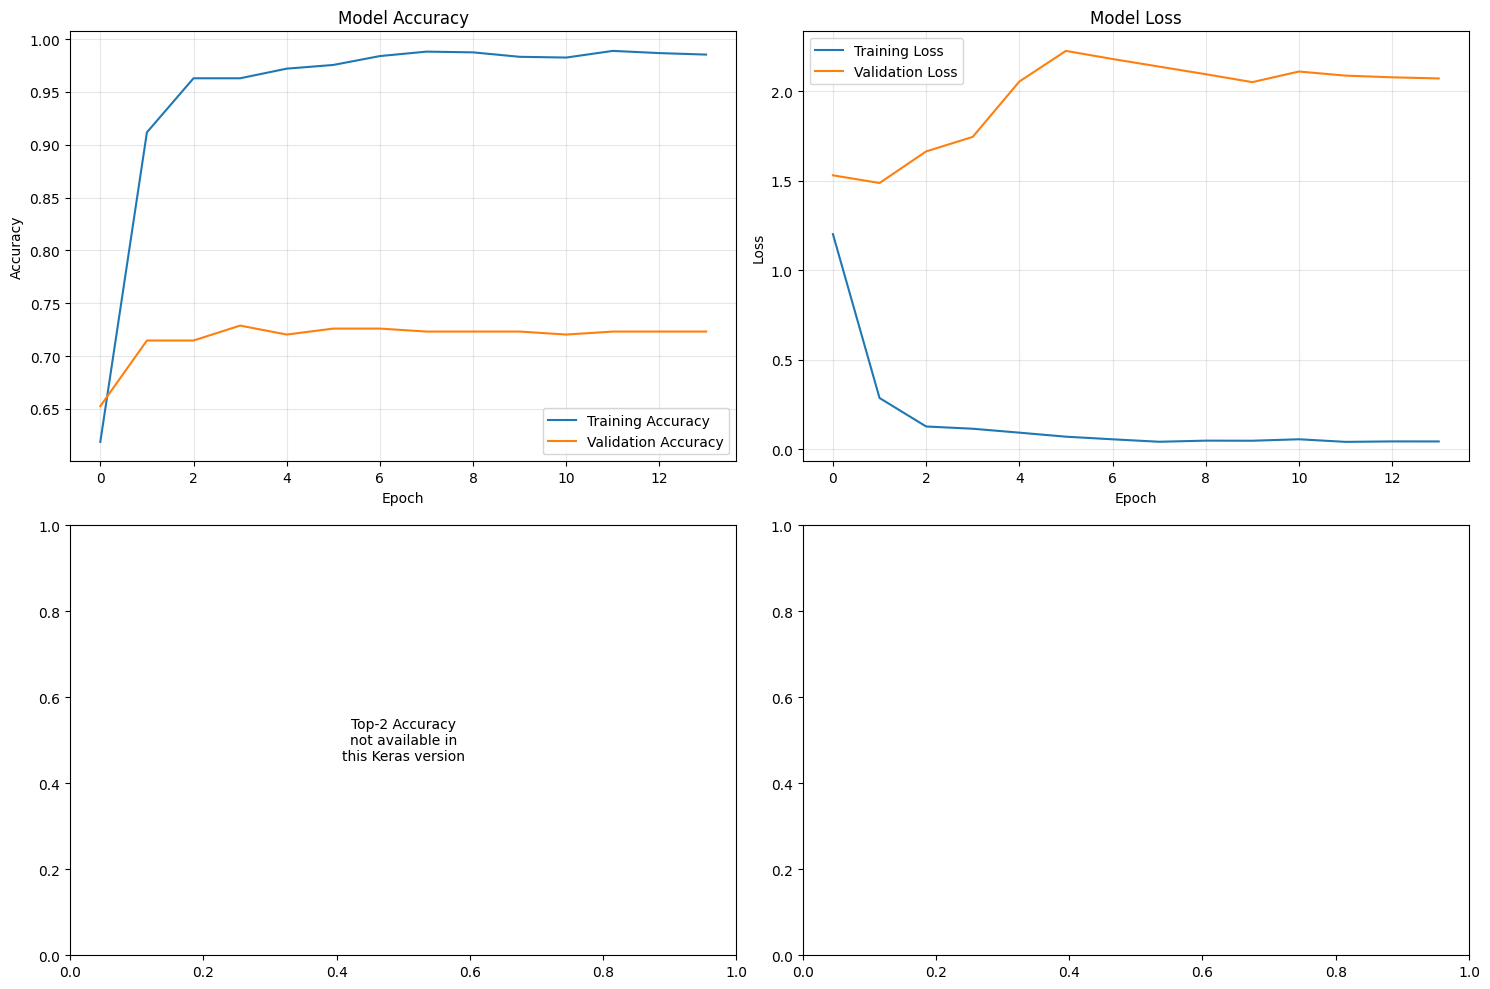


🔍 STEP 4: Pose Feedback System
✅ Dance Pose Feedback System is ready!

🎯 You can now:
   - Test with individual images: feedback_system.generate_feedback(image)
   - Process videos: VideoProcessor(feedback_system).process_video(video_path)
   - Save model: classifier.model.save('dance_pose_model.h5')


In [ ]:
classifier, feedback_system = main_pipeline()

In [ ]:
classifier.model.save('dance_pose_model.h5')

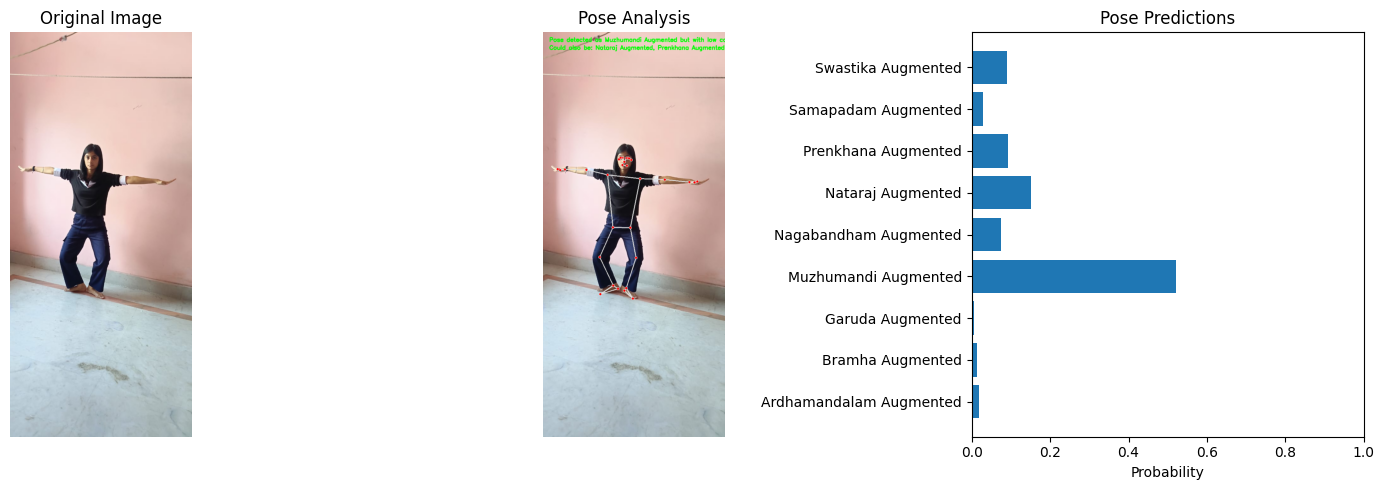

📋 Feedback Results:
   ⚠️ Pose detected as Muzhumandi Augmented but with low confidence (52.22%)
   💡 Could also be: Nataraj Augmented, Prenkhana Augmented


In [ ]:
test_single_image(feedback_system, '/content/pose 3.jpg')

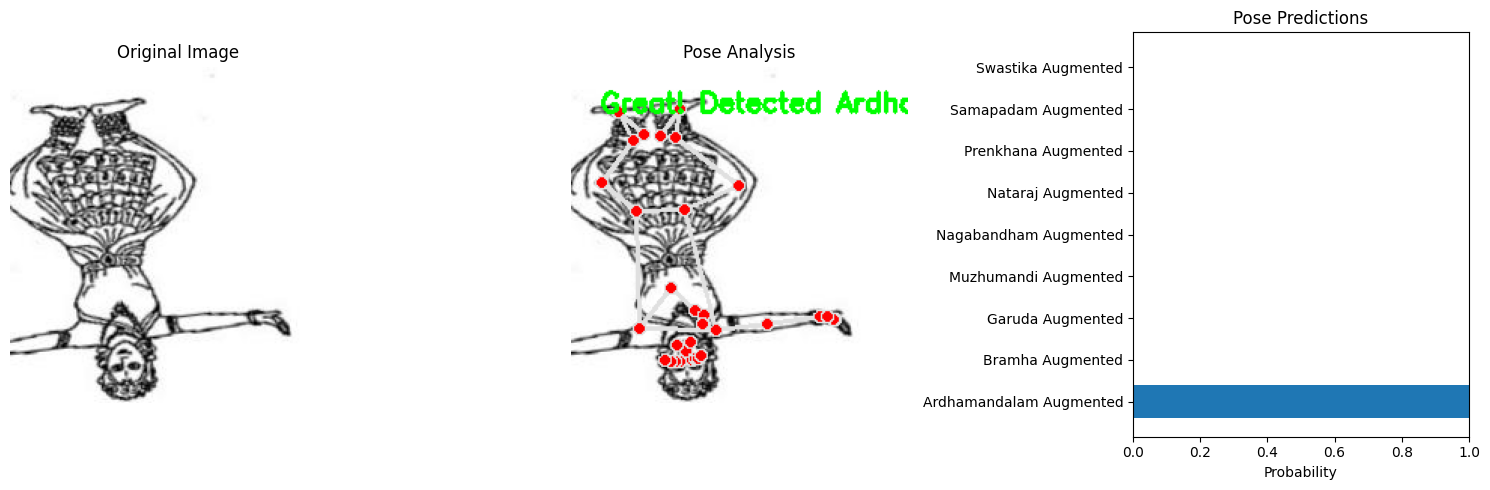

📋 Feedback Results:
   ✅ Great! Detected Ardhamandalam Augmented with high confidence (99.94%)


In [ ]:
test_single_image(feedback_system, '/content/drive/MyDrive/new_Dataset/Ardhamandalam Augmented/dr_0_1332.jpg')

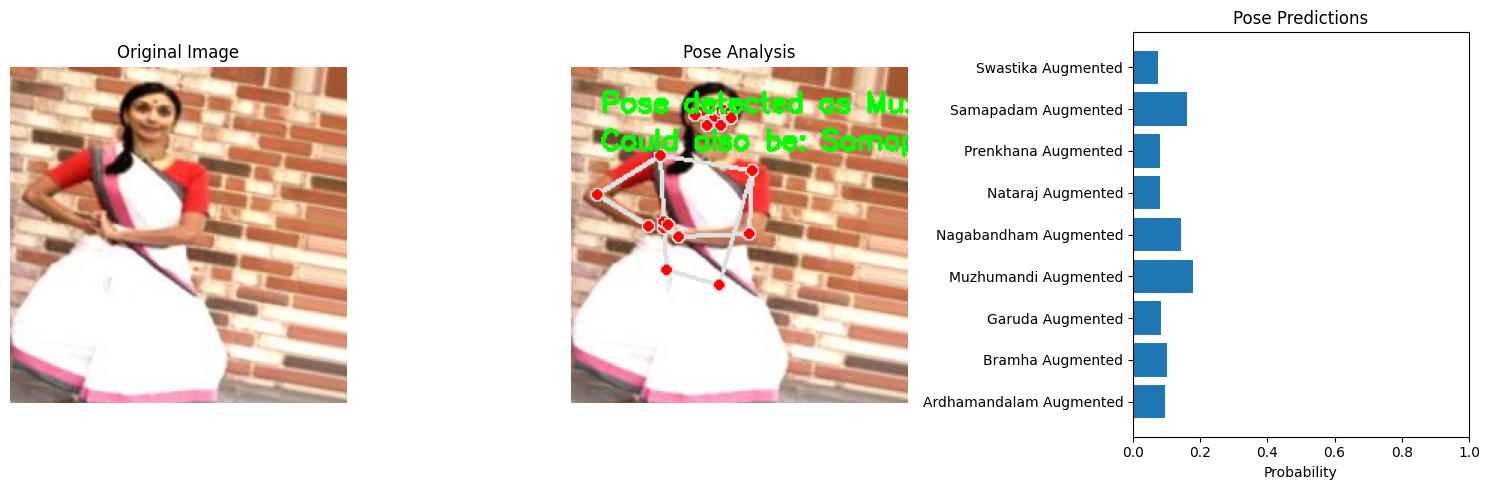

📋 Feedback Results:
   ⚠️ Pose detected as Muzhumandi Augmented but with low confidence (17.76%)
   💡 Could also be: Samapadam Augmented, Nagabandham Augmented


In [ ]:
test_single_image(feedback_system, '/content/drive/MyDrive/new_Dataset/Nagabandham Augmented/dr_0_1081.jpg')

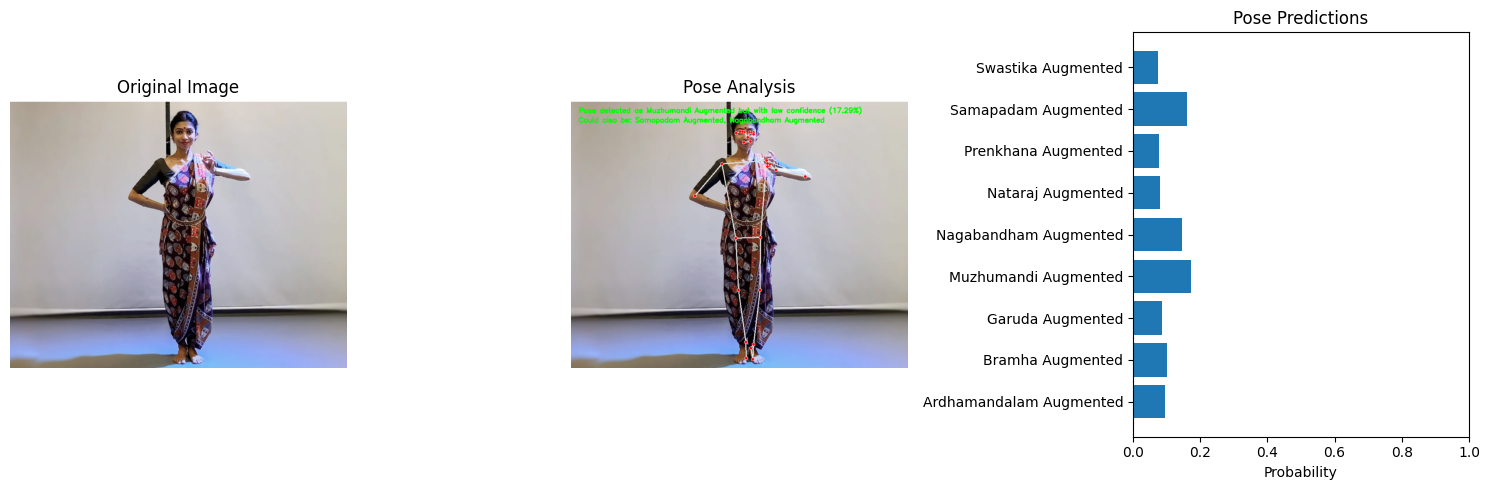

📋 Feedback Results:
   ⚠️ Pose detected as Muzhumandi Augmented but with low confidence (17.29%)
   💡 Could also be: Samapadam Augmented, Nagabandham Augmented


In [ ]:
test_single_image(feedback_system, '/content/sampadnam.png')
